# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2021spring-ta@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [1]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 


Next, set up virtual display，and import all necessaary packages.

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [3]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [4]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [5]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [6]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [7]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [8]:
random_action = env.action_space.sample()
print(random_action)

0


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [9]:
observation, reward, done, info = env.step(random_action)

In [10]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [11]:
print(reward)

-0.8588900517154912


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

In [12]:
# env.reset()

# img = plt.imshow(env.render(mode='rgb_array'))

# done = False
# while not done:
#     action = env.action_space.sample()
#     observation, reward, done, _ = env.step(action)

#     img.set_data(env.render(mode='rgb_array'))
#     display.display(plt.gcf())
#     display.clear_output(wait=True)

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [13]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities. 

In [14]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():
    
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
        
    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def sample(self, state, exploration_rate=0):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()

        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

Lastly, build a network and agent to start training.

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

from os import path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
SAVING_PATH = "/content/gdrive/MyDrive/ColabNotebooks/HW12/checkpoint"

network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

if path.exists(SAVING_PATH):
    checkpoint = torch.load(SAVING_PATH)
    network.load_state_dict(checkpoint)


## Trainin Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [31]:
agent.network.train()  # Switch network into training mode 
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 1000        # totally update the agent for 400 time

avg_total_rewards, avg_final_rewards = [], []

best_actions = []
best_rewards = float('-inf')

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    action_list = []
    env = gym.make('LunarLander-v2')
    fix(env, seed) # fix the environment Do not revise this !!!

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        actions = []

        while True:
            action, log_prob = agent.sample(state) # at, log(at|st)
            next_state, reward, done, _ = env.step(action)

            actions.append(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            # ! IMPORTANT !
            # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
            #                                                         rewards :     r1, r2 ,r3 ......
            # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
            #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement DQN
            if done:
                seq_rewards.reverse()
                rewards_tmp = []
                r_tot = 0
                for r in seq_rewards:
                    r_tot = r_tot * 0.99 + r
                    rewards_tmp.append(r_tot)

                rewards_tmp.reverse()
                for r in rewards_tmp:
                    rewards.append(r)

                final_reward = reward

                final_rewards.append(final_reward)
                total_rewards.append(total_reward)
                
                action_list.append(actions)
                break



    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # update agent
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward 
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

    checkpoint = network.state_dict()

    if avg_total_reward > best_rewards:
        best_rewards = avg_total_reward
        best_action_list = action_list
        print(f"best_rewards: {best_rewards}")

    torch.save(checkpoint, SAVING_PATH)

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


best_rewards: -8.42647613677525
best_rewards: 24.93856653162718
best_rewards: 51.4762886444121
best_rewards: 66.80767721900288
best_rewards: 71.45255315419259
best_rewards: 114.50073723891292
best_rewards: 259.1399063120759
best_rewards: 267.3544798362294
best_rewards: 280.1701302374842
best_rewards: 286.47043837087546



### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


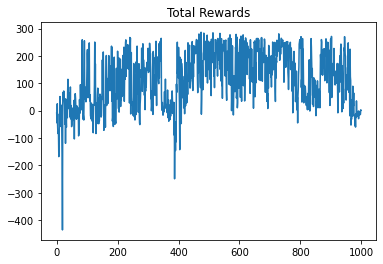

In [32]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


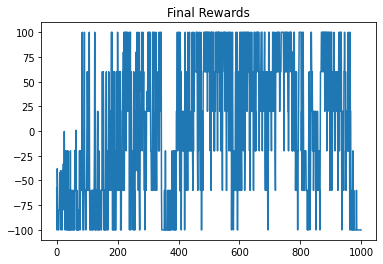

In [33]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

In [21]:
# fix(env, seed)
# agent.network.eval()  # set the network into evaluation mode
# NUM_OF_TEST = 5 # Do not revise this !!!

# test_total_reward = []
# action_list = []
# for i in range(NUM_OF_TEST):
#   actions = []
#   state = env.reset()

#   # img = plt.imshow(env.render(mode='rgb_array'))

#   total_reward = 0

#   done = False
#   while not done:
#       action, _ = agent.sample(state)
#       actions.append(action)
#       state, reward, done, _ = env.step(action)

#       total_reward += reward

#       # img.set_data(env.render(mode='rgb_array'))
#       # display.display(plt.gcf())
#       # display.clear_output(wait=True)
      
#   print(total_reward)
#   test_total_reward.append(total_reward)

#   action_list.append(actions) # save the result of testing 


In [22]:
# print(np.mean(test_total_reward))

Action list

In [23]:
# print("Action list looks like ", action_list)
# print("Action list's shape looks like ", np.shape(action_list))

Analysis of actions taken by agent

In [24]:
# distribution = {}
# for actions in action_list:
#   for action in actions:
#     if action not in distribution.keys():
#       distribution[action] = 1
#     else:
#       distribution[action] += 1
# print(distribution)

Saving the result of Model Testing


In [18]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(best_action_list)) 

### This is the file you need to submit !!!
Download the testing result to your device



In [26]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Server 
The code below simulate the environment on the judge server. Can be used for testing.

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


Your reward is : 270.09
Your reward is : 286.94
Your reward is : 296.97
Your reward is : 276.97
Your reward is : 301.38


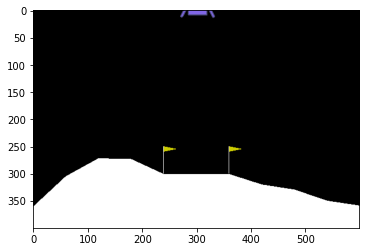

In [19]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this
fix(env, seed)

agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [20]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 286.47


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
